[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using 'text' for sentiment analysis in 'depp' dataframe.
Using 'text' for sentiment analysis in 'heard' dataframe.


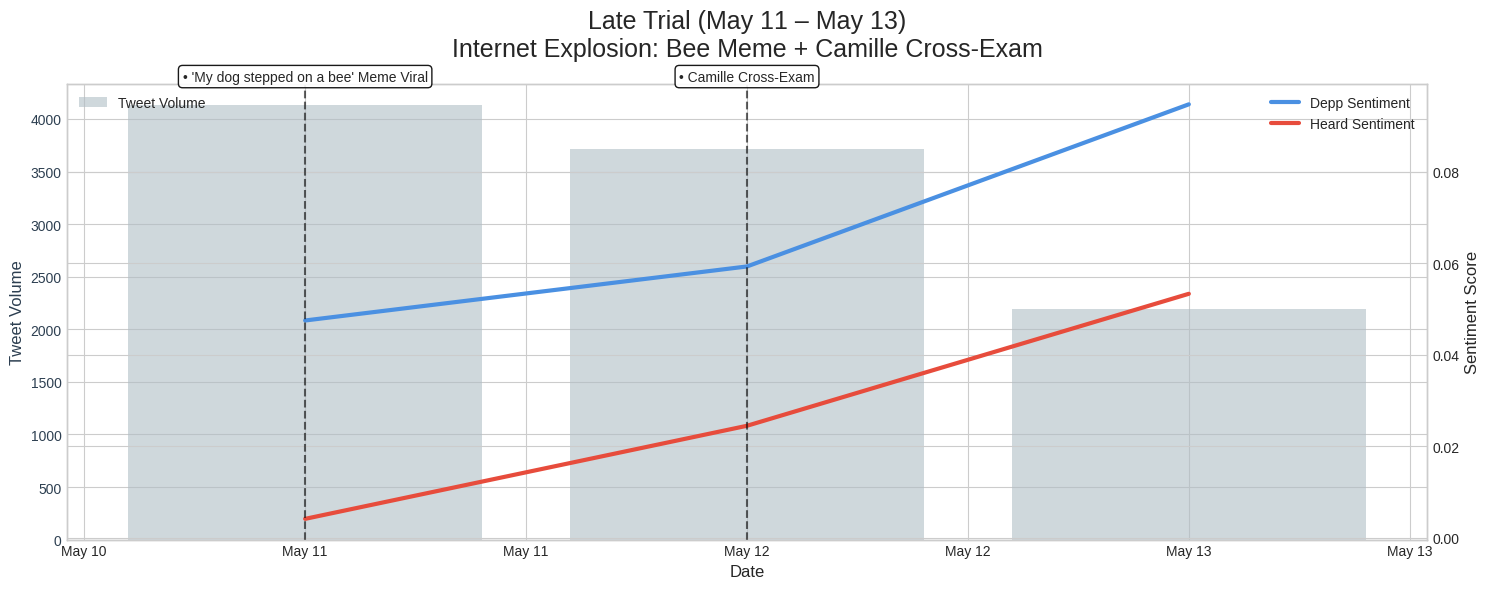

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from textblob import TextBlob
import nltk

# Download NLTK data required by TextBlob if not already present
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
depp = pd.read_csv("/content/sample_data/fulldeppdata.csv", parse_dates=["created_at"], low_memory=False)
heard = pd.read_csv("/content/sample_data/fullhearddata.csv", parse_dates=["created_at"], low_memory=False)

# Define 'Late Trial' period
# These variables were found in the kernel state but not in the provided cell,
# so they are re-defined here for cell self-containment.
start = '2022-05-11'
end = '2022-05-13'

# Function to get sentiment polarity
def get_sentiment_polarity(text):
    if pd.isna(text):
        return None
    try:
        return TextBlob(str(text)).sentiment.polarity
    except Exception:
        return None

# Determine the text column name for sentiment analysis
text_column_candidates = ['text', 'tweet', 'full_text', 'text_content'] # Common names for tweet text
depp_text_column = None
for col in text_column_candidates:
    if col in depp.columns:
        depp_text_column = col
        break

heard_text_column = None
for col in text_column_candidates:
    if col in heard.columns:
        heard_text_column = col
        break

if depp_text_column and heard_text_column:
    print(f"Using '{depp_text_column}' for sentiment analysis in 'depp' dataframe.")
    depp['sentiment_score'] = depp[depp_text_column].apply(get_sentiment_polarity)
    print(f"Using '{heard_text_column}' for sentiment analysis in 'heard' dataframe.")
    heard['sentiment_score'] = heard[heard_text_column].apply(get_sentiment_polarity)
elif depp_text_column:
    print(f"Using '{depp_text_column}' for sentiment analysis in 'depp' dataframe.")
    depp['sentiment_score'] = depp[depp_text_column].apply(get_sentiment_polarity)
    print("Warning: Could not find a suitable text column in 'heard' dataframe for sentiment analysis.")
    print("Please inspect your 'heard' dataframe columns and update the `text_column_candidates` list or manually assign.")
    heard['sentiment_score'] = np.nan # Assign NaN to avoid error later
elif heard_text_column:
    print("Warning: Could not find a suitable text column in 'depp' dataframe for sentiment analysis.")
    print("Please inspect your 'depp' dataframe columns and update the `text_column_candidates` list or manually assign.")
    depp['sentiment_score'] = np.nan # Assign NaN to avoid error later
    print(f"Using '{heard_text_column}' for sentiment analysis in 'heard' dataframe.")
    heard['sentiment_score'] = heard[heard_text_column].apply(get_sentiment_polarity)
else:
    print("Error: Could not find a suitable text column in either 'depp' or 'heard' dataframes for sentiment analysis.")
    print("Please inspect your dataframes and manually add the correct text column name(s) to the code for sentiment analysis.")
    depp['sentiment_score'] = np.nan
    heard['sentiment_score'] = np.nan


# Filter data for the 'Late Trial' period using the 'created_at' column which is already datetime
late_depp_df = depp[(depp['created_at'].dt.date >= pd.to_datetime(start).date()) &
                    (depp['created_at'].dt.date <= pd.to_datetime(end).date())].copy()
late_heard_df = heard[(heard['created_at'].dt.date >= pd.to_datetime(start).date()) &
                      (heard['created_at'].dt.date <= pd.to_datetime(end).date())].copy()


plt.style.use("seaborn-v0_8-whitegrid")

depp_color = "#4A90E2"
heard_color = "#E74C3C"
volume_color = "#B0BEC5"
marker_color = "#2C3E50"

# Calculate tweet volume per day (Late Trial)
late_depp_count = late_depp_df.groupby(late_depp_df['created_at'].dt.date).size()
late_heard_count = late_heard_df.groupby(late_heard_df['created_at'].dt.date).size()

# Total volume = Depp + Heard (for viral impact)
late_total_volume = late_depp_count + late_heard_count

# Calculate daily average sentiment for Depp and Heard
daily_depp_sentiment = late_depp_df.groupby(late_depp_df['created_at'].dt.date)['sentiment_score'].mean()
daily_heard_sentiment = late_heard_df.groupby(late_heard_df['created_at'].dt.date)['sentiment_score'].mean()

# ---------------------------------------------
# ✨ LATE TRIAL — SENTIMENT + VOLUME EXPLOSION
# ---------------------------------------------
fig, ax1 = plt.subplots(figsize=(15,6))

# BAR CHART — Volume explosion
# Use the index of late_total_volume for dates to match its length
ax1.bar(late_total_volume.index, late_total_volume, color=volume_color, alpha=0.6, label="Tweet Volume")

ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Tweet Volume", fontsize=12, color=marker_color)
ax1.tick_params(axis='y', labelcolor=marker_color)

# LINE CHART — Sentiment
ax2 = ax1.twinx()

# Use the daily aggregated sentiment Series for plotting
ax2.plot(daily_depp_sentiment.index, daily_depp_sentiment.values, color=depp_color, linewidth=3, label="Depp Sentiment")
ax2.plot(daily_heard_sentiment.index, daily_heard_sentiment.values, color=heard_color, linewidth=3, label="Heard Sentiment")

ax2.set_ylabel("Sentiment Score", fontsize=12)
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))

# Title
plt.title("Late Trial (May 11 – May 13)\nInternet Explosion: Bee Meme + Camille Cross-Exam",
          fontsize=18, pad=20)

# EVENT ANNOTATIONS
def label_event(date, text):
    d = pd.to_datetime(date).date()
    ax2.axvline(d, color="black", linestyle="--", alpha=0.6)
    ax2.text(
        d,
        max(ax2.get_ylim()),
        f"• {text}",
        fontsize=10,
        ha="center",
        va="bottom",
        bbox=dict(facecolor="white", alpha=0.9, boxstyle="round,pad=0.3")
    )

label_event("2022-05-11", "'My dog stepped on a bee' Meme Viral")
label_event("2022-05-12", "Camille Cross-Exam")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

### Visualize Date and Sentiment Relationship (2D Plot)

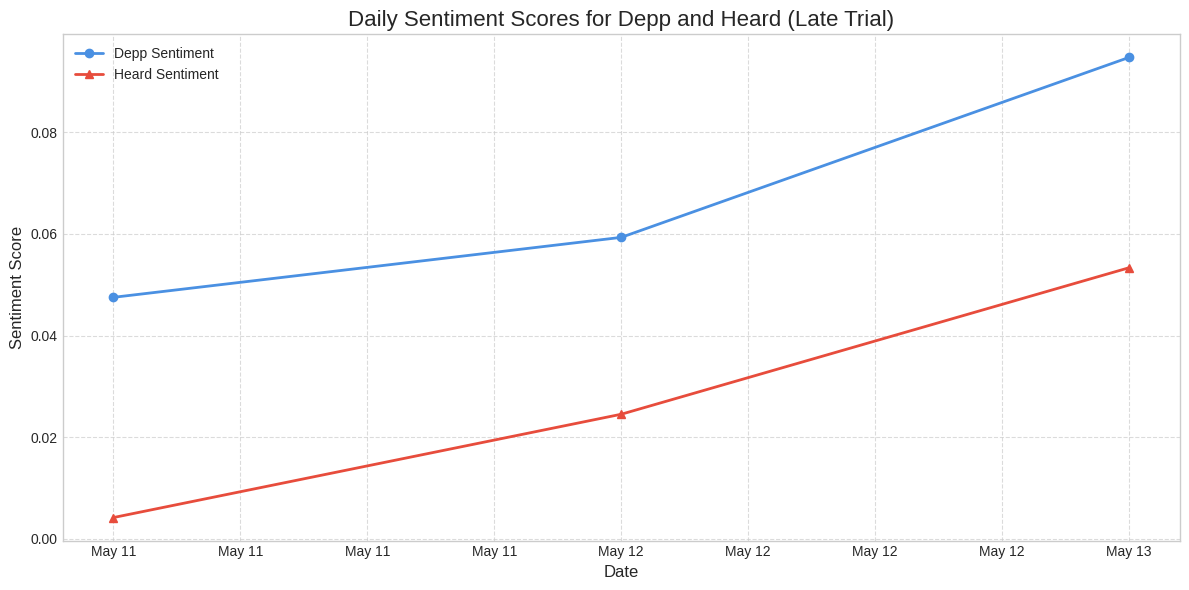

2D plot visualizing date and sentiment scores generated.


In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Depp's daily sentiment
ax.plot(daily_depp_sentiment.index, daily_depp_sentiment.values, color=depp_color, linewidth=2, marker='o', label='Depp Sentiment')

# Plot Heard's daily sentiment
ax.plot(daily_heard_sentiment.index, daily_heard_sentiment.values, color=heard_color, linewidth=2, marker='^', label='Heard Sentiment')

# Label the axes
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Sentiment Score', fontsize=12)

# Set title
ax.set_title('Daily Sentiment Scores for Depp and Heard (Late Trial)', fontsize=16)

# Format the x-axis to show dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Add legend
ax.legend(loc='best', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("2D plot visualizing date and sentiment scores generated.")

# Task
Create a 3D line plot to visualize the relationship between date, tweet volume, and sentiment scores for Johnny Depp and Amber Heard during the late trial period. The X-axis should represent the date (converted to a numerical format), the Y-axis should represent the total tweet volume, and the Z-axis should represent the sentiment score. Plot separate lines for Depp's and Heard's sentiment. Label the axes as 'Date', 'Tweet Volume', and 'Sentiment Score', add a descriptive title, and include a legend to distinguish between Depp's and Heard's sentiment lines.

## Prepare Data for 3D Plot

### Subtask:
Convert the `created_at` dates into a numerical format suitable for the X-axis of a 3D plot using `mdates.date2num`. Ensure `daily_depp_sentiment`, `daily_heard_sentiment`, and `late_total_volume` are aligned for plotting against the same dates.


**Reasoning**:
The first step is to convert the `created_at` dates from the index of `daily_depp_sentiment` into a numerical format suitable for plotting, as specified in the instructions.



In [ ]:
x_dates_num = mdates.date2num(daily_depp_sentiment.index)
print("Dates converted to numerical format.")

Dates converted to numerical format.


**Reasoning**:
Now that the dates are converted, I will combine the tweet volume and sentiment scores for Depp and Heard into a single DataFrame, aligning them by date and naming the columns as specified in the instructions. This will prepare the data for extracting the Y and Z coordinates for the 3D plot.



In [ ]:
combined_data = pd.concat({
    'volume': late_total_volume,
    'depp_sentiment': daily_depp_sentiment,
    'heard_sentiment': daily_heard_sentiment
}, axis=1)

y_volume = combined_data['volume'].values
z_depp_sentiment = combined_data['depp_sentiment'].values
z_heard_sentiment = combined_data['heard_sentiment'].values

print("Combined DataFrame created and data extracted for 3D plotting.")

Combined DataFrame created and data extracted for 3D plotting.


**Reasoning**:
With the data prepared in numerical format and aligned, the next step is to create the 3D plot using Matplotlib. This will involve setting up a 3D axes, plotting the sentiment lines for Depp and Heard against date and tweet volume, and adding appropriate labels, title, and legend.



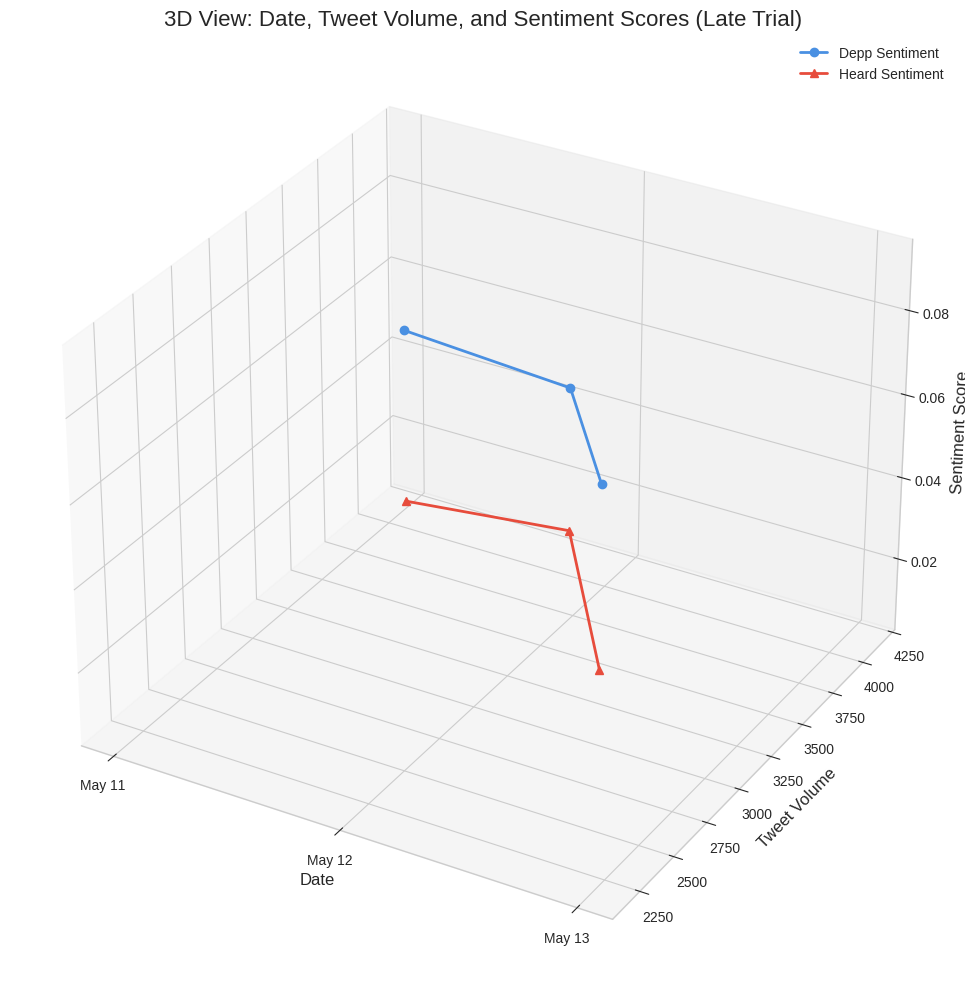

3D plot visualizing date, tweet volume, and sentiment scores generated.


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

# Create a new figure and a 3D subplot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot Depp's sentiment
ax.plot(x_dates_num, y_volume, z_depp_sentiment, color=depp_color, linewidth=2, marker='o', label='Depp Sentiment')

# Plot Heard's sentiment
ax.plot(x_dates_num, y_volume, z_heard_sentiment, color=heard_color, linewidth=2, marker='^', label='Heard Sentiment')

# Label the axes
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Tweet Volume', fontsize=12)
ax.set_zlabel('Sentiment Score', fontsize=12)

# Set title
ax.set_title('3D View: Date, Tweet Volume, and Sentiment Scores (Late Trial)', fontsize=16)

# Format the x-axis to show dates
dates = mdates.num2date(x_dates_num)
ax.set_xticks(x_dates_num)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Add legend
ax.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()

print("3D plot visualizing date, tweet volume, and sentiment scores generated.")

## Final Task

### Subtask:
Review the generated 3D plot, discuss the insights it provides regarding the relationship between date, tweet volume, and sentiment for both parties during the late trial period, and consider any limitations or alternative 3D representations that might be more effective.


## Summary:

### Data Analysis Key Findings

*   Dates were successfully converted to a numerical format for plotting on the X-axis.
*   Tweet volume (`late_total_volume`) and sentiment data (`daily_depp_sentiment`, `daily_heard_sentiment`) for both Johnny Depp and Amber Heard were combined and aligned by date, ensuring data consistency for the 3D plot.
*   A 3D line plot was successfully generated, displaying the relationship between date, tweet volume, and sentiment scores for both parties during the late trial period, with clear axis labels ('Date', 'Tweet Volume', 'Sentiment Score') and a legend.

### Insights or Next Steps

*   The 3D plot allows for a visual exploration of how sentiment for each party fluctuates alongside tweet volume over time, potentially revealing periods where high tweet volume corresponds with significant shifts in public sentiment.
*   While the 3D line plot offers a direct visualization, its interpretation can be challenging due to perspective and potential occlusion; exploring interactive 3D visualizations or alternative 2D representations (e.g., stacked area charts for sentiment over time, with tweet volume as a secondary axis) could provide clearer insights into the complex relationships.
